# Optimizers

```text
- This refers to the algorithm that adjusts the weights during backprop.
- Stochastic Gradient Descent (SGD) is the vanilla gradient descent algorithm.
- Other optimizers are variants of SGD and the goal is to smooth the descent.
```

$$W = W - \eta.dL$$
where \
$W$ = Weights \
$\eta$ = Learning rate \
$dL$ = Gradient (Derivative)

<br><hr>

### Vanilla SGD

```text
- The weights are updated after each sample.
- It's great when all the samples are similar to each other.
- SGD is very sensitive and can lead to valaitle changes.
```


### Mini-batch SGD

```text
- The weights are updated after N samples. i.e. losses are calculated after N samples.
- It's more robust than SGD except when the samples are similar to each other.
```

In [1]:
# Built-in library
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Configure the backend
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

# Custom import
from src.utilities import create_iris_data, create_qwerties_data, smooth, load_data
from src.preprocessor import Standardizer, Normalizer


# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

### Momentum

```text
- Smoothing via weighted averaging.
- Each data point is a weighted combination of itself and the previous data point.
- SGD with momentum updates the current weights according to a weighted average of current and previous costs.
```

$$V_{t} = (1 - \beta).V_{t} + \beta_{v_{t - 1}}$$

where \
$V_{t}$ is the vector of time
$\beta$ is a scaling factor between 0 and 1.

$$\beta \in \{0, 1\}$$


- Typical values of $\beta$ are 0.9 to 0.99.


In [1]:
# Built-in library
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Configure the backend
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

# Custom import
from src.utilities import create_iris_data, create_qwerties_data, smooth, load_data
from src.preprocessor import Standardizer, Normalizer


# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

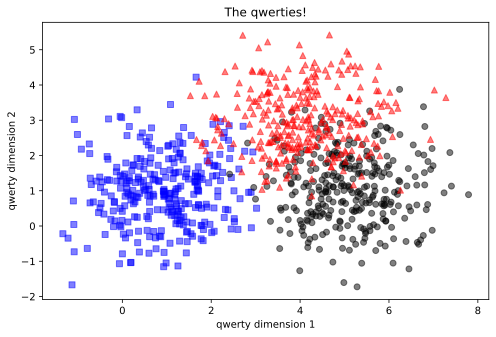

In [2]:
X, y = create_qwerties_data()

fig = plt.figure(figsize=(8, 5))
plt.plot(X[np.where(y == 0)[0], 0], X[np.where(y == 0)[0], 1], "bs", alpha=0.5)
plt.plot(X[np.where(y == 1)[0], 0], X[np.where(y == 1)[0], 1], "ko", alpha=0.5)
plt.plot(X[np.where(y == 2)[0], 0], X[np.where(y == 2)[0], 1], "r^", alpha=0.5)
plt.title("The qwerties!")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

In [3]:
np.unique(y)

array([0, 1, 2])

In [4]:
# Split the data
TEST_SIZE, RANDOM_STATE = 0.2, 123
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_validation.shape, y_train.shape

(torch.Size([720, 2]), torch.Size([180, 2]), torch.Size([720]))

In [5]:
BATCH_SIZE = 16
# Create Dataset objects
train_data = TensorDataset(X_train, y_train)
validation_data = TensorDataset(X_validation, y_validation)

# Create DataLoader objects
train_DL = DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)
validation_DL = DataLoader(
    dataset=validation_data, batch_size=validation_data.tensors[0].shape[0]
)

In [6]:
# Model Architecture
class Net(nn.Module):
    """This is an ANN architecture used for classification."""

    def __init__(self, n_units: int = 32) -> None:
        super().__init__()
        self.input = nn.Linear(2, n_units)
        self.hidden = nn.Linear(n_units, n_units)
        self.output = nn.Linear(n_units, 3)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to implement forward prop."""
        X = F.relu(self.input(X))
        X = F.relu(self.hidden(X))
        X = torch.softmax(self.output(X), dim=1)
        return X


def train_model(
    *,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    epochs: int,
    learning_rate: float,
    momentum: float
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """This is used to train the ANN model."""
    net, PCT = Net(), 100
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        params=net.parameters(), lr=learning_rate, momentum=momentum
    )
    train_accuracy, validation_accuracy = np.zeros(shape=(epochs,)), np.zeros(
        shape=(epochs,)
    )
    train_loss = np.zeros(shape=(epochs,))

    for epoch_idx in np.arange(epochs):
        net.train()
        batch_loss, batch_accuracy = [], []

        for X_, y_ in train_dataloader:
            # Reset gradients
            optimizer.zero_grad()

            # Forward prop and loss
            y_proba = net(X_)
            loss = criterion(y_proba, y_)

            # Back prop
            loss.backward()
            optimizer.step()

            # Batch loss and ccuracy
            batch_loss.append(loss.detach())
            y_pred = torch.argmax(y_proba, dim=1)
            acc = torch.mean((y_pred == y_).float()) * PCT
            batch_accuracy.append(acc.detach())

        # Training loss
        train_loss[epoch_idx] = np.mean(batch_loss)
        train_accuracy[epoch_idx] = np.mean(batch_accuracy)

        # Validation loss
        net.eval()

        X_val, y_val = next(iter(validation_dataloader))
        y_pred_val = torch.argmax(net(X_val), dim=1)
        acc_ = torch.mean((y_pred_val == y_val).float()) * PCT
        validation_accuracy[epoch_idx] = acc_.detach()

    return (train_accuracy, validation_accuracy, train_loss)

In [8]:
EPOCHS, LEARNING_RATE, MOMENTUM = 1_000, 0.01, 0.9
train_accuracy, validation_accuracy, train_loss = train_model(
    train_dataloader=train_DL,
    validation_dataloader=validation_DL,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    momentum=MOMENTUM,
)

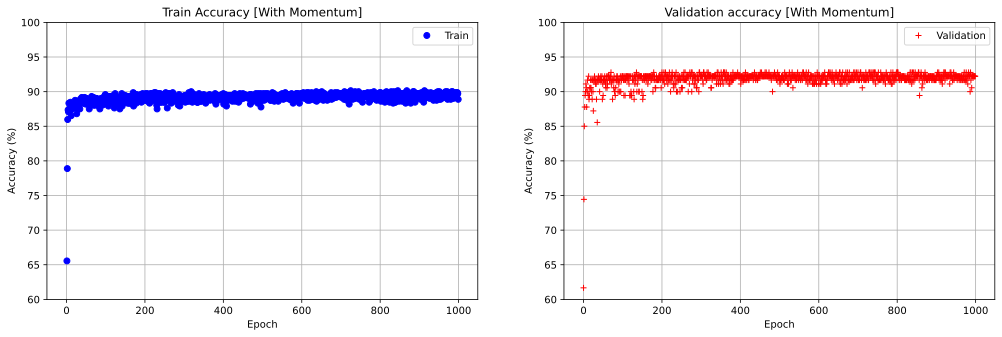

In [13]:
# Visualize the results
fig, ax = plt.subplots(1, 2, figsize=(17, 5))

ax[0].plot(train_accuracy, "bo", label="Train")
ax[0].set_title("Train Accuracy [With Momentum]")

ax[1].plot(validation_accuracy, "r+", label="Validation")
ax[1].set_title("Validation accuracy [With Momentum]")

# Common features
for idx in range(2):
    ax[idx].legend()
    ax[idx].set_xlabel("Epoch")
    ax[idx].set_ylabel("Accuracy (%)")
    ax[idx].set_ylim(60, 100)
    ax[idx].grid()

plt.show()

<br><hr>

### RMSprop

```text
- RMS: Root Mean Square.
- Prop: Propagation. i.e. forward/backward.
- It's similar to momentum. It's the process of biasing the weight changes using dampened previous gradients.
- The learning rate is biased using the magnitude of the gradient instead of biasing the gradient.
- The step size for adjusting the weight depends on the history of the gradients' magnnitudes.
- When the gradients are large, it translates to smaller step while small gradients mean large step.
RMSprop is less affected by the choice of the initial learning rate and it automatically implements learning rate decay.
```

$$RMS = \sqrt{\frac{1}{n}\sum^n_{i=1}{x^{2}_{i}}}$$
$$STD = \sqrt{\frac{1}{n}\sum^n_{i=1}{(x_{i} - \bar{x_{i}})^{2}}}$$

RMSprop:
$$ s = (1 - \beta)(dJ)^{2} + \beta_{s_{t-1}} $$
$$W = W - \frac{\eta}{\sqrt{s + \epsilon}}$$
where \
$s$ = Weighted average of the derivative of the square of the cost function. \
$\epsilon$ = A small value which prevents the denominator from becoming zero.

<br><br>

### Adam

```text
- It's the combination of momentum and RMSprop.
- Adam optimizer is generally considered the current best.
```

$$V_{t} = (1 - \beta_{1}).V_{t} + \beta_{1.v_{t - 1}}$$
$$s = (1 - \beta_{2})(dJ)^{2} + \beta_{2.s_{t-1}}$$
$$W = W - \frac{\eta}{\sqrt{s + \epsilon}}$$

- Typical parameter values are: \
$\eta$ = 0.01 \
$\beta_{1}$ = 0.9 \
$\beta_{2}$ = 0.999 \
$\epsilon_{1}$ = 10E-8

In [22]:
# Model Architecture
class Net(nn.Module):
    """This is an ANN architecture used for classification."""

    def __init__(self, n_units: int = 32) -> None:
        super().__init__()
        self.input = nn.Linear(2, n_units)
        self.hidden = nn.Linear(n_units, n_units)
        self.output = nn.Linear(n_units, 3)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to implement forward prop."""
        X = F.relu(self.input(X))
        X = F.relu(self.hidden(X))
        X = torch.softmax(self.output(X), dim=1)
        return X


def train_model(
    *,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    epochs: int,
    learning_rate: float,
    optimizer_name: str
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """This is used to train the ANN model."""
    net, PCT = Net(), 100
    criterion = nn.CrossEntropyLoss()
    _optimizer_ = getattr(torch.optim, optimizer_name)
    optimizer = _optimizer_(params=net.parameters(), lr=learning_rate)
    train_accuracy, validation_accuracy = np.zeros(shape=(epochs,)), np.zeros(
        shape=(epochs,)
    )
    train_loss = np.zeros(shape=(epochs,))

    for epoch_idx in np.arange(epochs):
        net.train()
        batch_loss, batch_accuracy = [], []

        for X_, y_ in train_dataloader:
            # Reset gradients
            optimizer.zero_grad()

            # Forward prop and loss
            y_proba = net(X_)
            loss = criterion(y_proba, y_)

            # Back prop
            loss.backward()
            optimizer.step()

            # Batch loss and ccuracy
            batch_loss.append(loss.detach())
            y_pred = torch.argmax(y_proba, dim=1)
            acc = torch.mean((y_pred == y_).float()) * PCT
            batch_accuracy.append(acc.detach())

        # Training loss
        train_loss[epoch_idx] = np.mean(batch_loss)
        train_accuracy[epoch_idx] = np.mean(batch_accuracy)

        # Validation loss
        net.eval()

        X_val, y_val = next(iter(validation_dataloader))
        y_pred_val = torch.argmax(net(X_val), dim=1)
        acc_ = torch.mean((y_pred_val == y_val).float()) * PCT
        validation_accuracy[epoch_idx] = acc_.detach()

    return (train_accuracy, validation_accuracy, train_loss, net)

In [18]:
EPOCHS, LEARNING_RATE, OPTIMIZERS = 500, 0.01, ["SGD", "RMSprop", "Adam"]
train_accuracy, validation_accuracy = (
    np.zeros(shape=(EPOCHS, len(OPTIMIZERS))),
    np.zeros(shape=(EPOCHS, len(OPTIMIZERS))),
)

for idx, optimizer in enumerate(OPTIMIZERS):
    train_acc, validation_acc, _ = train_model(
        train_dataloader=train_DL,
        validation_dataloader=validation_DL,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        optimizer_name=optimizer,
    )
    train_accuracy[:, idx] = train_acc
    validation_accuracy[:, idx] = validation_acc

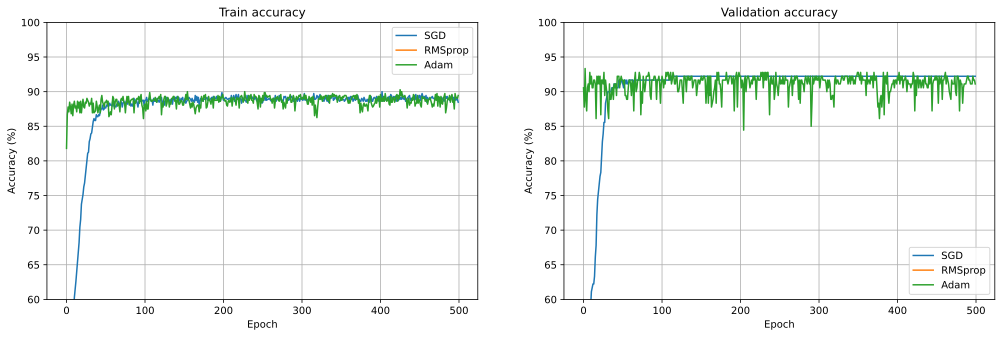

In [20]:
# Visualize the results
fig, ax = plt.subplots(1, 2, figsize=(17, 5))

ax[0].plot(train_accuracy)
ax[0].set_title("Train accuracy")

ax[1].plot(validation_accuracy)
ax[1].set_title("Validation accuracy")

# Common features
for idx in range(2):
    ax[idx].legend(OPTIMIZERS)
    ax[idx].set_xlabel("Epoch")
    ax[idx].set_ylabel("Accuracy (%)")
    ax[idx].set_ylim(60, 100)
    ax[idx].grid()

plt.show()

In [37]:
def plot_the_results(
    *,
    trained_model: Net,
    X: torch.Tensor,
    y: torch.Tensor,
    train_acc: np.ndarray,
    validation_acc: np.ndarray,
    losses: np.ndarray,
    optimizer_name: str,
):

    # compute accuracy over entire dataset (train+test)
    y_pred = trained_model(X)
    predictions = torch.argmax(y_pred, axis=1)
    accuracy = (predictions == y).float()
    totalAcc = torch.mean(100 * accuracy).item()

    # and accuracy by group
    accuracy_by_group = np.zeros(3)
    for idx in range(3):
        accuracy_by_group[idx] = 100 * torch.mean(accuracy[y == idx])

    # create the figure
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))

    # Plot the loss function
    ax[0, 0].plot(losses)
    ax[0, 0].set_ylabel("Loss")
    ax[0, 0].set_xlabel("Epoch")
    ax[0, 0].set_title(f"{optimizer_name}: Losses")

    # Plot the accuracy functions
    ax[0, 1].plot(train_acc, label="Train")
    ax[0, 1].plot(validation_acc, label="Test")
    ax[0, 1].set_ylabel("Accuracy (%)")
    ax[0, 1].set_xlabel("Epoch")
    ax[0, 1].set_title(f"{optimizer_name}: Accuracy")
    ax[0, 1].legend()

    # Plot overall accuracy by group
    ax[1, 0].bar(range(3), accuracy_by_group)
    ax[1, 0].set_ylim([np.min(accuracy_by_group) - 5, np.max(accuracy_by_group) + 5])
    ax[1, 0].set_xticks([0, 1, 2])
    ax[1, 0].set_xlabel("Group")
    ax[1, 0].set_ylabel("Accuracy (%)")
    ax[1, 0].set_title(f"{optimizer_name}: Accuracy by group")

    # Scatterplot of correct and incorrect labeled data
    colorShapes = ["bs", "ko", "g^"]  # data markers
    for idx in range(3):
        # Plot all data points
        ax[1, 1].plot(
            X[y == idx, 0],
            X[y == idx, 1],
            colorShapes[idx],
            alpha=0.3,
            label=f"Group {idx}",
        )

        # Cross-out the incorrect ones
        idxErr = (accuracy == 0) & (y == idx)
        ax[1, 1].plot(X[idxErr, 0], X[idxErr, 1], "rx")

    ax[1, 1].set_title(f"{optimizer_name}: Total accuracy: {totalAcc:.2f}%")
    ax[1, 1].set_xlabel("qwerty dimension 1")
    ax[1, 1].set_ylabel("qwerty dimension 2")
    ax[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [34]:
optimizer_name = "Adam"

train_acc, validation_acc, losses, trained_net = train_model(
    train_dataloader=train_DL,
    validation_dataloader=validation_DL,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optimizer_name=optimizer_name,
)

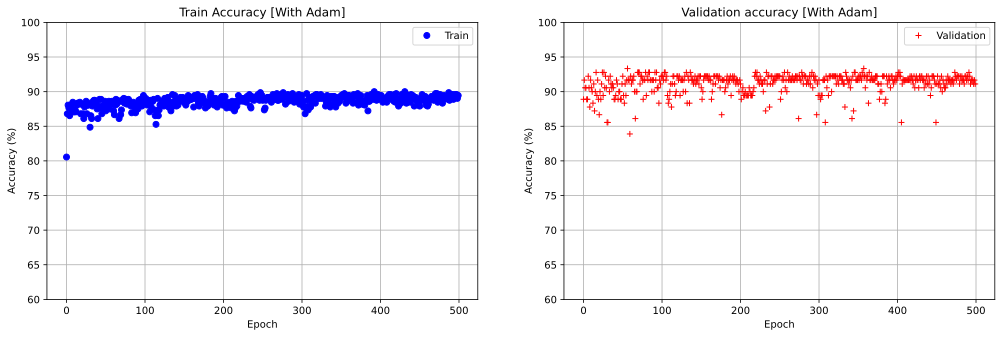

In [35]:
# Visualize the results
fig, ax = plt.subplots(1, 2, figsize=(17, 5))

ax[0].plot(train_acc, "bo", label="Train")
ax[0].set_title(f"Train Accuracy [With {optimizer_name}]")

ax[1].plot(validation_acc, "r+", label="Validation")
ax[1].set_title(f"Validation accuracy [With {optimizer_name}]")

# Common features
for idx in range(2):
    ax[idx].legend()
    ax[idx].set_xlabel("Epoch")
    ax[idx].set_ylabel("Accuracy (%)")
    ax[idx].set_ylim(60, 100)
    ax[idx].grid()

plt.show()

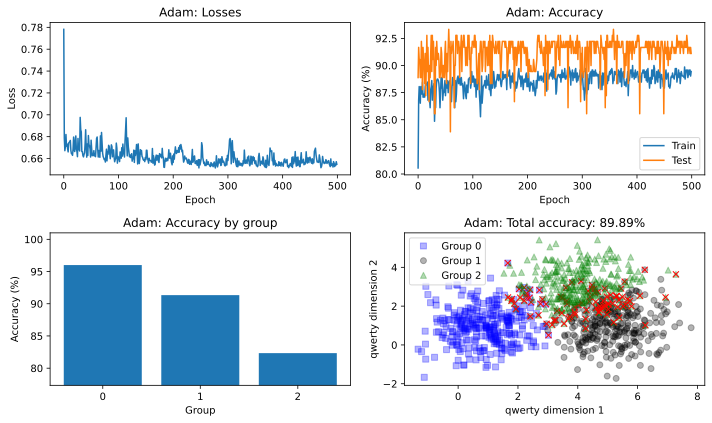

In [38]:
plot_the_results(
    trained_model=trained_net,
    X=X,
    y=y,
    train_acc=train_acc,
    validation_acc=validation_acc,
    losses=losses,
    optimizer_name=optimizer_name,
)

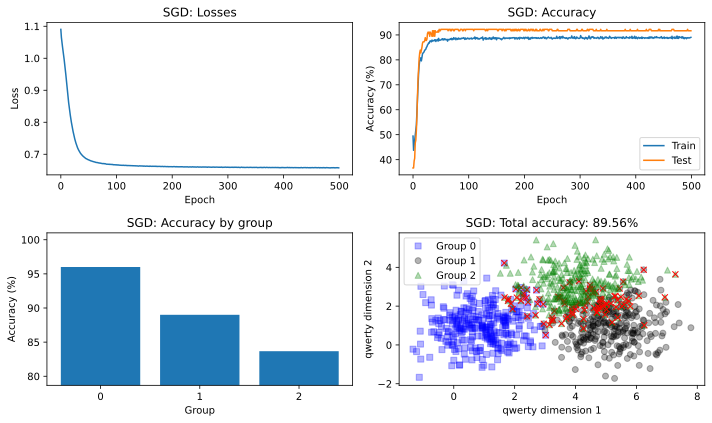

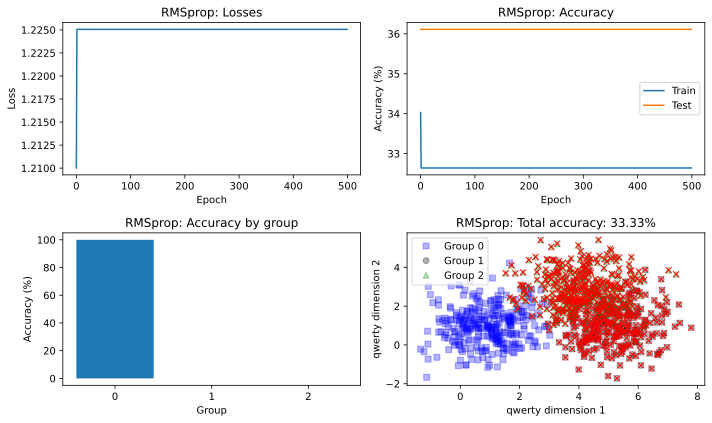

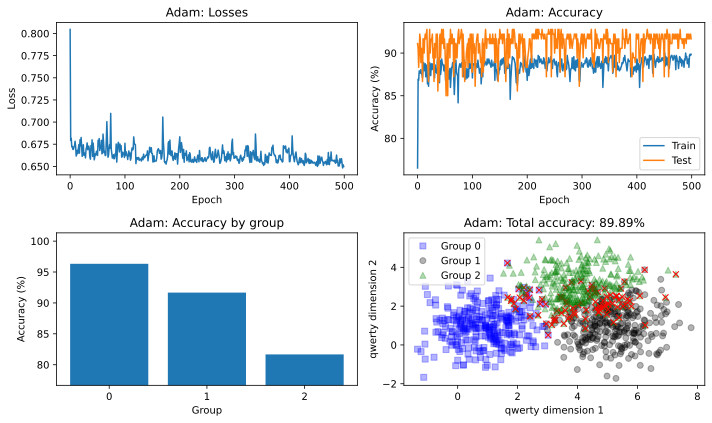

['SGD: train 88.8%, test 91.7%',
 'RMSprop: train 32.6%, test 36.1%',
 'Adam: train 89.4%, test 91.9%']

In [39]:
EPOCHS, LEARNING_RATE, OPTIMIZERS = 500, 0.01, ["SGD", "RMSprop", "Adam"]
# Average performance
performance = []

for optimizer_name in OPTIMIZERS:
    train_acc, validation_acc, losses, trained_net = train_model(
        train_dataloader=train_DL,
        validation_dataloader=validation_DL,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        optimizer_name=optimizer_name,
    )
    # Plot the visuals for each optimizer
    plot_the_results(
        trained_model=trained_net,
        X=X,
        y=y,
        train_acc=train_acc,
        validation_acc=validation_acc,
        losses=losses,
        optimizer_name=optimizer_name,
    )

    # Store the final results
    train = np.mean(train_acc[-10:])
    test = np.mean(validation_acc[-10:])

    performance.append(f"{optimizer_name}: train {train:.1f}%, test {test:.1f}%")


In [40]:
performance

['SGD: train 88.8%, test 91.7%',
 'RMSprop: train 32.6%, test 36.1%',
 'Adam: train 89.4%, test 91.9%']

In [ ]:
EPOCHS, LEARNING_RATE, OPTIMIZERS = 500, 0.01, ["SGD", "RMSprop", "Adam"]
train_accuracy, validation_accuracy = (
    np.zeros(shape=(EPOCHS, len(OPTIMIZERS))),
    np.zeros(shape=(EPOCHS, len(OPTIMIZERS))),
)

for idx, optimizer in enumerate(OPTIMIZERS):
    train_acc, validation_acc, _ = train_model(
        train_dataloader=train_DL,
        validation_dataloader=validation_DL,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        optimizer_name=optimizer,
    )
    train_accuracy[:, idx] = train_acc
    validation_accuracy[:, idx] = validation_acc